# Chicago Criminal Dataset

In [1]:
import pyspark
!pip install plotly

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col
import pyspark.sql as sql
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px

In [3]:
spark = SparkSession.builder\
      .master("local[*]")\
      .appName("ChicagoCriminalProject")\
      .getOrCreate() 

In [4]:
dataset = spark.read.csv("Crimes_-_2001_to_Present.csv", inferSchema=True, header =True)

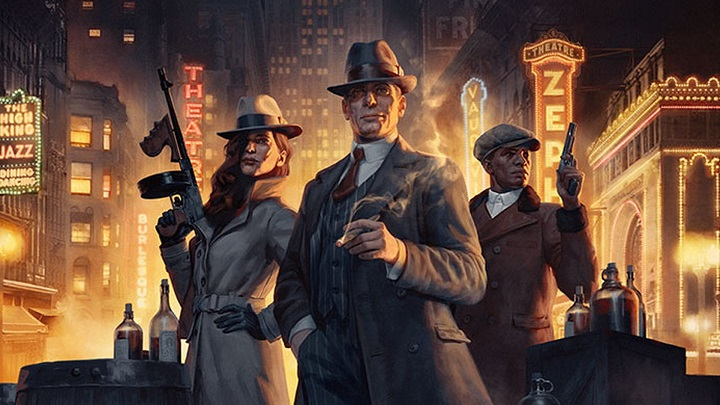

In [5]:
dataset = dataset.dropna(subset=('latitude','longitude','Date'))

In [6]:
dataset = dataset.withColumn("Date", to_timestamp(dataset.Date, 'MM/dd/yyyy hh:mm:ss a'))

In [7]:
dataset.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [8]:
dataset.limit(5).toPandas()

ID Case Number                Date  \
0  11665567    JC234307 2019-04-10 16:37:00   
1  11667963    JC235212 2019-04-12 16:08:00   
2  11667968    JC237058 2019-04-19 13:57:00   
3  11668309    JC238187 2019-04-25 17:20:00   
4  11692179    JC261724 2019-05-13 17:26:00   

                                 Block  IUCR                Primary Type  \
0                   102XX S VERNON AVE  1562                 SEX OFFENSE   
1                   032XX N KEELER AVE  1754  OFFENSE INVOLVING CHILDREN   
2                  002XX N LARAMIE AVE  1752  OFFENSE INVOLVING CHILDREN   
3  108XX S DR MARTIN LUTHER KING JR DR  0486                     BATTERY   
4                   090XX S RACINE AVE  0560                     ASSAULT   

                                         Description  \
0                   AGGRAVATED CRIMINAL SEXUAL ABUSE   
1                     AGG SEX ASSLT OF CHILD FAM MBR   
2  AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER   
3                            DOMESTIC BATTERY SIMPLE   
4                                             SIMPLE   

       Location Description  Arrest  Domestic  ...  Ward  Community Area  \
0  SCHOOL - PUBLIC BUILDING   False     False  ...     9              49   
1                 RESIDENCE   False      True  ...    30              16   
2                 RESIDENCE   False      True  ...    28              25   
3                 RESIDENCE   False      True  ...     9              49   
4                    STREET   False     False  ...    21              73   

   FBI Code  X Coordinate Y Coordinate  Year              Updated On  \
0        17       1181051      1837225  2019  04/17/2020 03:50:24 PM   
1        02       1147835      1921408  2019  10/02/2019 04:13:24 PM   
2        17       1141669      1901165  2019  03/18/2020 03:52:17 PM   
3       08B       1180832      1833222  2019  06/30/2019 03:56:27 PM   
4       08A       1169908      1844927  2019  06/30/2019 03:56:27 PM   

    Latitude  Longitude                       Location  
0  41.708589 -87.612583     (41.708589, -87.612583094)  
1  41.940298 -87.732066  (41.940297617, -87.732066473)  
2  41.884865 -87.755230  (41.884865037, -87.755230327)  
3  41.697609 -87.613508  (41.697609261, -87.613507612)  
4  41.729973 -87.653167  (41.729973132, -87.653166753)  

[5 rows x 22 columns]

## Самые часто совершаемые преступления

Рассмотрим количество преступлений различных типов, совершенных в Чикаго в период с 2001 года по настоящее время.

In [9]:
d_grouped = dataset.groupby("Primary Type").count().orderBy('count', ascending=0)

labels = [row["Primary Type"] for row in d_grouped.collect()]
values = [row["count"] for row in d_grouped.collect()]

fig = go.Figure(data=[go.Bar(x = labels, y = values)])
fig.update_layout(
    title="Number of crimes committed from 2001 to present",
    xaxis_title="Crime type",
    yaxis_title="Number of crimes"
)
fig.show()

Самыми частыми преступлениями в Чикаго являются кражи, побои, нанесение материального ущерба, преступления связанные с наркотиками, преступные нападения и кражи со взломом.

Рассмотрим распределение типов преступлений по годам и выведем 5 самых часто совершаемых преступлений за каждый год.

In [10]:
often_crimes = dataset.groupby("Year", "Primary Type").count()

In [11]:
window = Window.partitionBy(often_crimes['Year']).orderBy(often_crimes['count'].desc())

top_often_crimes = often_crimes.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 5)\
                                        .orderBy('Year').toPandas()

In [12]:
crime_types = top_often_crimes['Primary Type'].unique()
years = top_often_crimes['Year'].unique()

In [13]:
fig = go.Figure()
for crime in crime_types:
    d_grouped = top_often_crimes[top_often_crimes['Primary Type'] == crime]
    
    labels = d_grouped['Year'].values
    values = d_grouped['count'].values

    fig.add_trace(go.Bar(x = labels, y = values, width=0.15, name = crime))

fig.update_layout(
    title="Top 5 most frequently committed crimes by years",
    xaxis_title="Year",
    yaxis_title="Number of crimes",
    xaxis = dict(
        tickmode = 'array',
        tickvals = years
    )
)
fig.show()

В целом количество преступлений в Чикаго с каждым годом снижалось. Весь период с 2001 по 2020 год самыми частыми преступлениями являются кражи, побои и нанесение материального ущерба. Также до 2015 года включительно с этот список входили преступления, связанные с наркотиками, но начиная с 2016 стало возрастать число мошенников. Нападений было меньше в период с 2002 по 2012 год, однако с 2016 года они возобновились. С 2009 по 2012 года было большое количество краж со взломом..

## Процент раскрываемости преступлений по годам

In [14]:
num_crimes = dataset.groupby('Year').count().orderBy('Year')

In [15]:
num_solved_crimes = dataset.filter(dataset["Arrest"] == True)\
                           .groupBy("Year").count().withColumnRenamed('count', 'count_solved').orderBy('Year')

In [16]:
num_solved_crimes = num_solved_crimes.join(num_crimes, 'Year')\
                                     .withColumn('percent of solved crimes', 
                                                 F.col('count_solved') / F.col('count')).toPandas()

In [17]:
fig = go.Figure()
x = num_solved_crimes['Year']
y = num_solved_crimes['percent of solved crimes']
fig.add_trace(go.Bar(x=x, y=y))
fig.update_layout(
    title="Percentage of crimes solved by years",
    xaxis_title="Year",
    yaxis_title="Percentage",
    xaxis = dict(
        tickmode = 'array',
        tickvals = years
    )
)
fig.show()

В среднем около 30% процентов всех преступлений раскрывались, но с 2016 года этот процент резко упал до 19.

## Преступления с наименьшей раскрываемостью

Выведем процент раскрываемости каждого типа преступлений

In [18]:
num_crimes_by_types = dataset.groupby('Primary Type').count()

In [19]:
num_solved_crimes_by_types = dataset.filter(dataset["Arrest"] == True)\
                                    .groupBy("Primary Type").count().withColumnRenamed('count', 'count_solved')

In [20]:
solved_types = num_solved_crimes_by_types.join(num_crimes_by_types, 'Primary Type')\
                                         .withColumn('percent of solved crimes', 
                                                     F.col('count_solved') / F.col('count'))
solved_types = solved_types.orderBy('percent of solved crimes', ascending=0).toPandas()

In [21]:
fig = go.Figure()
x = solved_types['Primary Type']
y = solved_types['percent of solved crimes']
fig.add_trace(go.Bar(x=x, y=y))
fig.update_layout(
    title="Percentage of different types of crimes solved",
    xaxis_title="Crime type",
    yaxis_title="Percentage",
    xaxis = dict(
        tickmode = 'array',
        tickvals = x.values
    )
)
fig.show()

К преступлениям с наименьшей раскрываемостью относятся кражи со взломом, нанесение ущерба, сексуальное насилие, угон транспортных средств, грабежи, торговля людьми и похищение детей.

## Процентное соотношение количества домашнего насилия

In [22]:
dataset.createOrReplaceTempView("chicago")
domestic = spark.sql("SELECT count(Domestic) AS domestic_count FROM chicago GROUP BY Domestic")

In [23]:
domestic = domestic.toPandas()

In [24]:
values = domestic.values
sum_ = domestic.values[0] + domestic.values[1]
dom_per = values[0]/sum_
nondom_per = values[1]/sum_

domestic['percentage'] = [dom_per[0], nondom_per[0]]

fig = px.pie(domestic, values='percentage', names=['domestic', 'non-domestic'], title='Percentage of domestic')
fig.show()


По данным видно, что домашнее насилие в районах Чикаго составляет 13.4% от общего числа преступлений

## Исследование влияния коронавируса на преступность

In [25]:
dataset = dataset.withColumn("arrest_month", sql.functions.month(sql.functions.col("Date")))

dataset.createOrReplaceTempView("chicago")
pandemic_months = spark.sql("SELECT 'Case Number', Year, arrest_month FROM chicago WHERE arrest_month in (3,4,5)")

In [26]:
pandemic_months.groupby("Year").count().show()

+----+------+
|Year| count|
+----+------+
|2003|119311|
|2007|111829|
|2018| 66418|
|2015| 65873|
|2006|112675|
|2013| 78294|
|2014| 69624|
|2019| 64779|
|2004|118252|
|2020| 46311|
|2012| 85719|
|2009|100048|
|2016| 66246|
|2001|121771|
|2005|115510|
|2010| 97342|
|2011| 89269|
|2008|106171|
|2017| 65041|
|2002|116967|
+----+------+



In [27]:
pandemic_months_domestic = spark.sql('''SELECT 'Case Number', Year, arrest_month 
                            FROM chicago 
                            WHERE arrest_month in (3,4,5) AND Domestic = True
                            ORDER BY Year DESC''')

pandemic_months_domestic = pandemic_months_domestic.groupby("Year").count().sort("Year").toPandas()


In [28]:
mean_ = pandemic_months_domestic['count'].mean()
fig = px.bar(pandemic_months_domestic, x='Year', y='count', template="simple_white", title="Crimes In Pandemic Time")
fig.add_shape(
    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
    x0=0, x1=1, xref="paper", y0=mean_, y1=mean_, yref="y"
)
fig.update_layout(
    font_family="Rockwell",
)
fig.add_annotation( # add a text callout with arrow
    text="below mean value!", x="2020", y=9800, arrowhead=1, showarrow=True, bgcolor='salmon'
)
fig.show()

Мы собрали статистику по годам в месяцы первой волны пандемии, март, апрель и май. Можно видеть, что во время короновирусной инфекции число преступлений меньше чем за 10 лет до этого. Также хорошо видно, что общая тендеция преступности снижается.

In [29]:
months = spark.sql('''SELECT COUNT('Case Number') AS count_arrest, Year, arrest_month 
                      FROM chicago
                      GROUP BY arrest_month, Year
                      ORDER BY count_arrest DESC''')

In [30]:
months.show()

+------------+----+------------+
|count_arrest|Year|arrest_month|
+------------+----+------------+
|       44967|2002|           7|
|       44370|2001|           7|
|       43755|2001|           8|
|       43581|2003|           8|
|       43262|2002|           8|
|       43109|2004|           7|
|       43059|2003|           7|
|       42921|2004|           8|
|       42829|2003|          10|
|       42794|2001|          10|
|       42045|2002|           5|
|       41891|2002|           6|
|       41792|2002|          10|
|       41580|2001|           5|
|       41567|2005|           7|
|       41464|2001|           6|
|       41402|2004|          10|
|       41398|2006|           7|
|       41390|2002|           9|
|       41262|2005|           8|
+------------+----+------------+
only showing top 20 rows



In [31]:
months = months.toPandas()

In [32]:
fig = px.pie(months, values='count_arrest', names='arrest_month', title='Most Criminal Month')
fig.show()

Также было интересно узнать, какой месяц является самым криминальным. Но как оказалось, престпуления распределены по месяцам довольно равномерно и нет одного какого-то явно выраженного преступного месяца.

## Зависимость преступности от времени года

In [33]:
from pyspark.sql.types import LongType
from pyspark.sql.functions import udf, col

def get_season(x):
    if x in [1,2,12]:
        return 'winter'
    if x in [3,4,5]:
        return 'spring'
    if x in [6,7,8]:
        return 'summer'
    else:
        return 'autumn'

units_udf = udf(lambda x: get_season(x))
seasons_crime = dataset.withColumn("season", units_udf(col("arrest_month"))).withColumnRenamed('Primary Type', 'crime_type')

In [34]:
seasons_crime.createOrReplaceTempView("seasons_crime")
seasons_crime_count = spark.sql('''SELECT crime_type, COUNT(crime_type) as crime_frequancy, season
                            FROM seasons_crime 
                            GROUP BY crime_type, season
                            ORDER BY crime_frequancy DESC''')

In [35]:
seasons_crime = seasons_crime_count.toPandas()

In [36]:
fig = px.histogram(seasons_crime, x="crime_type", y="crime_frequancy", color="season",
            title="Relationship of the crimes with seasons",
            width=1000, height=800,
            
            color_discrete_map={ # replaces default color mapping by value
                "winter": "RebeccaPurple", "Female": "MediumPurple"
            },
            template="simple_white"
            )
fig.update_layout(
    xaxis_title="Crime Type",
    yaxis_title="Crime frequancy")

fig.show()

Данная же визуализация отвечает на вопрос взаимоотношения времени года и преступности в районах Чикаго. Можно видеть, что преступность не зависит от времени года и соответственно от погоды. Преступления совершаются как в летнее, так и в зимнее время примерно с одинаковой частотой.

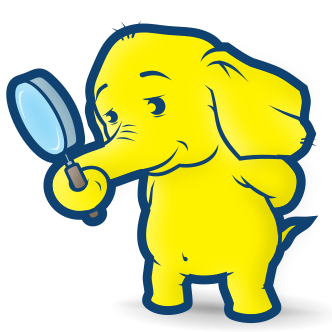 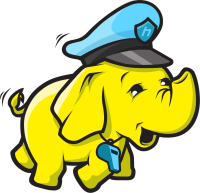

____
Таким образом, была произведена аналитика с помощью Pyspark криминальных районов Чикаго, исследованы такие вопросы как самые часто совершаемые преступления, процент раскрываемости, как повлиял короновирус. Была произведена визуализация поставленных вопросов и построена карта криманальных районов Чикаго  